# Botnet Logistic Regression Classifier

Cross Validation implementation of logistic regression for classification.

### Preprocessing

The `readFile` function in Python uses PySpark to read data from a specified file, process it, and return it as an RDD. Each row in the file is transformed into a record consisting of a tuple, where the first element is a list of 11 floating-point feature values, and the second element is an integer label (0 or 1). 

In [24]:
import os
from pyspark import SparkContext


def readFile(filename):
    """
    Return an RDD containing the data of filename.
    Each example (row) of the file corresponds to one RDD record.
    Each record of the RDD is a tuple (X,y). “X” is an array containing the 11
    features (float number) of an example
    “y” is the 12th column of an example (integer 0/1)
    """

    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    sc = SparkContext.getOrCreate()
    data = sc.textFile(parent_directory + "/" + filename)
    processed_data = data.map(lambda line: line.split(",")).map(
        lambda cols: ([float(x) for x in cols[:11]], float(cols[11]))
    )
    return processed_data


### Normalizing

The `normalize` function, using PySpark, takes an RDD as input and normalizes its features. It first calculates the total number of samples, then proceeds to compute the sum and sum of squares for each feature across all samples. Utilizing the map and reduce functions, it aggregates these values to calculate the mean and variance for each feature. It then computes the standard deviation, handling cases to avoid division by zero. The mean and standard deviation are broadcasted to all nodes. Finally, it applies normalization to each record (feature vector) in the RDD, adjusting each feature to have a mean of 0 and a standard deviation of 1, and returns the normalized RDD.

In [25]:
import numpy as np

def normalize(RDD_Xy):
    sc = SparkContext.getOrCreate()

    number_of_samples = RDD_Xy.count()

    # Function to compute sum and sum of squares for each feature
    def compute_sum_and_squares(record):
        X, _ = record
        return (np.array(X), np.array(X) ** 2)

    # Aggregate the sum and sum of squares for each feature, and count the examples
    sum_squares_count = RDD_Xy.map(compute_sum_and_squares).reduce(
        lambda a, b: (a[0] + b[0], a[1] + b[1])
    )

    # Calculate the mean and variance for each feature
    mean = sum_squares_count[0] / number_of_samples
    variance = (sum_squares_count[1] / number_of_samples) - mean**2
    std_dev = np.sqrt(variance)

    # Replace zeros in standard deviation with ones to avoid division by zero
    std_dev[std_dev == 0] = 1

    # Broadcast the mean and std_dev to all the nodes
    broadcast_mean = sc.broadcast(mean)
    broadcast_std_dev = sc.broadcast(std_dev)

    # Function to normalize features
    def normalize_features(record):
        X, y = record
        X_normalized = (X - broadcast_mean.value) / broadcast_std_dev.value
        return (X_normalized, y)

    # Normalize each feature and return the new RDD
    return RDD_Xy.map(normalize_features)


### Transform

The `transform` function in Python, using PySpark, adds a random index between 0 and `num_blocks - 1` to each record in an RDD, effectively assigning each record to a random fold for cross-validation. It achieves this through the `map` function, which applies the `add_index` nested function to each record, returning a new RDD where each element is a tuple of the original record and its randomly assigned index.

In [26]:
import random

def transform(RDD_Xy, num_blocks):
    # Function to assign a random index to each record
    def add_index(record):
        # Randomly select an index between 0 and num_blocks - 1
        index = random.randint(0, num_blocks - 1)
        # Return a new record with the index added
        return (record, index)

    # Map each record in the RDD to include a random fold index
    RDD_tranformed = RDD_Xy.map(add_index)
    return RDD_tranformed


### Get Block Data

The `get_block_data` function in Python, using PySpark, splits an RDD into two subsets based on a specified block number. It creates training data (`tr_data`) by excluding records with the given block number, and testing data (`test_data`) by including only records with that block number, using the `flatMap` function for filtering.

In [27]:
def get_block_data(data_cv, block_numb):
    """
    Splits the input RDD into two RDDs based on the index value.

    :param data_cv: An RDD where each row is a list of size 11, y, and index.
    :param block_numb: The block number to split the RDD.
    :return: A tuple of two RDDs (tr_data, test_data).
    """

    # Split the data into two RDDs based on the index value

    def filter_block_train(record):
        if record[1] != block_numb:
            return [record[0]]
        else:
            return []

    def filter_block_test(record):
        if record[1] == block_numb:
            return [record[0]]
        else:
            return []

    tr_data = data_cv.flatMap(filter_block_train)
    test_data = data_cv.flatMap(filter_block_test)

    return tr_data, test_data


### Training

The `train` function in PySpark performs logistic regression training on an RDD. It iterates through a specified number of iterations, broadcasting weights and bias, computing gradients, and updating the model parameters using gradient descent. Auxiliary functions `compute_gradients` and `compute_cost` calculate gradients and cost for each data point, aiding in weight updates and cost monitoring for each iteration. The function is designed for distributed execution in a Spark environment.

In [28]:
def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    sc = SparkContext.getOrCreate()

    # Number of features (assuming all records have the same number of features)
    k = len(RDD_Xy.first()[0])
    m = RDD_Xy.count()  # Total number of examples

    np.random.seed(0)  # For reproducibility
    w = np.random.rand(k)  # Weight vector
    b = np.random.rand()  # Bias term

    for i in range(iterations):
        # Broadcast weights and bias
        broadcast_w = sc.broadcast(w)
        broadcast_b = sc.broadcast(b)

        # Compute gradients
        gradients = RDD_Xy.map(
            lambda x: compute_gradients(x, broadcast_w.value, broadcast_b.value, k)
        ).reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]))

        # Update weights and bias
        w -= learning_rate * ((1 / m) * gradients[0] + (lambda_reg / k) * w)
        b -= learning_rate * (
            (1 / m) * gradients[1] + ((lambda_reg / (2 * k)) * np.sum(w**2))
        )

        # Optional: Print cost for monitoring (not recommended for large datasets)
        cost = RDD_Xy.map(
            lambda x: compute_cost(x, broadcast_w.value, broadcast_b.value, k)
        ).reduce(lambda x, y: x + y)
        cost = (-1 / m) * cost
        cost += (lambda_reg / (2 * k)) * np.sum(w**2)
        
    return w, b


def compute_gradients(record, w, b, k):
    X, y = record
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    dw = (y_hat - y) * X
    db = np.sum(y_hat - y)
    return dw, db


def compute_cost(record, w, b, k):
    X, y = record
    z = 0
    for i in range(k):
        z += X[i] * w[i]
    z += b
    y_hat = 1 / (1 + np.exp(-z))
    cost = y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
    return cost


### Predict

The `predict` function computes a logistic regression prediction for a given feature vector `X` using provided weights `w` and bias `b`. It calculates the linear combination of features and weights, adds the bias, then applies the sigmoid function to determine the probability of the instance belonging to the positive class. Based on this probability, it returns a binary class label (0 or 1).

In [29]:
def predict(w, b, X):
    # Initialize the sum
    z = 0
    # Iterate over the weights and corresponding features
    for i in range(len(w)):
        z += w[i] * X[i]
        # Add the bias term
    z += b

    # compact way to calculate it z = np.dot(w, X) + b

    # Apply the sigmoid function to get the probability
    p = 1 / (1 + np.exp(-z))
    # Predict the class label (0 or 1) based on the probability
    if p >= 0.5:
        return 1
    else:
        return 0


### Accuracy

The `accuracy` function evaluates the performance of a logistic regression model on an RDD dataset by calculating its accuracy. It maps each record in the RDD to 1 or 0, based on whether the model's prediction matches the actual label, using the `predict` function. The function then sums these values using `reduce` to count correct predictions and divides this sum by the total number of records in the RDD to compute the overall accuracy.

In [30]:
def accuracy(w, b, RDD_xy):
    prediction_results = RDD_xy.map(
        lambda record: 1 if predict(w, b, record[0]) == record[1] else 0
    )

    # Step 2: Use reduce to sum up the correct predictions
    correctly_classified = prediction_results.reduce(lambda a, b: a + b)

    # Step 4: Calculate accuracy
    accuracy = correctly_classified / RDD_xy.count()
    return accuracy


### Testing

This Python script, designed to be run with PySpark, measures the performance of a machine learning workflow with varying numbers of cores. It sets up the Spark environment, reads and normalizes data, then performs 10-fold cross-validation using a logistic regression model, calculating accuracy for each fold. The script iterates over two different numbers of cores (12 and 15) to measure execution times, which are recorded in `execution_times`. After each run, SparkContext is stopped and reinitialized with a different configuration. The script aims to evaluate the impact of parallelization on the overall execution time of the machine learning workflow.

In [31]:
import sys
import pyspark
import matplotlib.pyplot as plt
import time

if __name__ == "__main__":
    os.environ["PYSPARK_PYTHON"] = sys.executable
    os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

    execution_times = []
    speed_up = []
    for i in [3,9, 12]:
        start_time = time.time()
        number_cores = i
        conf = (
            pyspark.SparkConf()
            .setMaster('local[{}]'.format(number_cores))
        )

        sc = pyspark.SparkContext(conf=conf)
        # read data
        data = readFile("/data/botnet_tot_syn_l.csv")
        # standardize
        data = normalize(data)
    
        num_blocks_cv = 10
        # Shuffle rows and transform data
        data_cv = transform(data, num_blocks_cv)
        # optimize performance
        data_cv_cached = data_cv.cache()
    
        accuracies = []
        for i in range(num_blocks_cv):
            tr_data, test_data = get_block_data(data_cv_cached, i)
            # optimize performance
            tr_data_cached = tr_data.cache()
            test_data_cached = test_data.cache()
            weights, bias = train(tr_data_cached, 10, 1.5, 0.05)
            acc = accuracy(weights, bias, test_data_cached)
            accuracies.append(acc)
            print("accuracy:", acc)
            print("------------------------------------------------------")
        avg_acc = 0
        for a in accuracies:
            avg_acc += a
        print("average accuracy:", avg_acc / num_blocks_cv)
        execution_times.append(time.time() - start_time)
        sc.stop()


23/12/17 20:43:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/17 20:43:12 WARN BlockManager: Task 18 already completed, not releasing lock for rdd_5_0


accuracy: 0.9327865733369384
------------------------------------------------------


23/12/17 20:43:53 WARN BlockManager: Task 226 already completed, not releasing lock for rdd_31_0


accuracy: 0.9307759302453625
------------------------------------------------------


23/12/17 20:44:31 WARN BlockManager: Task 434 already completed, not releasing lock for rdd_57_0


accuracy: 0.9301362636487603
------------------------------------------------------


23/12/17 20:45:09 WARN BlockManager: Task 642 already completed, not releasing lock for rdd_83_0


accuracy: 0.9301395601193646
------------------------------------------------------


23/12/17 20:45:47 WARN BlockManager: Task 850 already completed, not releasing lock for rdd_109_0


accuracy: 0.9306061576650518
------------------------------------------------------


23/12/17 20:46:26 WARN BlockManager: Task 1058 already completed, not releasing lock for rdd_135_0


accuracy: 0.9300329116935644
------------------------------------------------------


23/12/17 20:47:04 WARN BlockManager: Task 1266 already completed, not releasing lock for rdd_161_0


accuracy: 0.9294500070228946
------------------------------------------------------


23/12/17 20:47:41 WARN BlockManager: Task 1474 already completed, not releasing lock for rdd_187_0


accuracy: 0.9327572914685063
------------------------------------------------------


23/12/17 20:48:19 WARN BlockManager: Task 1682 already completed, not releasing lock for rdd_213_0


accuracy: 0.9314606516692018
------------------------------------------------------


23/12/17 20:48:57 WARN BlockManager: Task 1890 already completed, not releasing lock for rdd_239_0


accuracy: 0.9317524927742051
------------------------------------------------------
average accuracy: 0.9309897839643849


23/12/17 20:49:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/17 20:49:39 WARN BlockManager: Task 18 already completed, not releasing lock for rdd_5_0


accuracy: 0.9315311720698254
------------------------------------------------------


23/12/17 20:49:58 WARN BlockManager: Task 226 already completed, not releasing lock for rdd_31_0


accuracy: 0.9317293233082706
------------------------------------------------------


23/12/17 20:50:15 WARN BlockManager: Task 434 already completed, not releasing lock for rdd_57_0


accuracy: 0.9316831881847735
------------------------------------------------------


23/12/17 20:50:33 WARN BlockManager: Task 642 already completed, not releasing lock for rdd_83_0


accuracy: 0.9317500275808118
------------------------------------------------------


23/12/17 20:50:50 WARN BlockManager: Task 850 already completed, not releasing lock for rdd_109_0


accuracy: 0.93089852873655
------------------------------------------------------


23/12/17 20:51:08 WARN BlockManager: Task 1058 already completed, not releasing lock for rdd_135_0


accuracy: 0.9302869650782175
------------------------------------------------------


23/12/17 20:51:25 WARN BlockManager: Task 1266 already completed, not releasing lock for rdd_161_0


accuracy: 0.9312928232058014
------------------------------------------------------


23/12/17 20:51:42 WARN BlockManager: Task 1474 already completed, not releasing lock for rdd_187_0


accuracy: 0.9293514575500393
------------------------------------------------------


23/12/17 20:52:00 WARN BlockManager: Task 1682 already completed, not releasing lock for rdd_213_0


accuracy: 0.9309594539547545
------------------------------------------------------


23/12/17 20:52:17 WARN BlockManager: Task 1890 already completed, not releasing lock for rdd_239_0


accuracy: 0.9304438307920119
------------------------------------------------------
average accuracy: 0.9309926770461056


23/12/17 20:52:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/17 20:52:39 WARN BlockManager: Task 18 already completed, not releasing lock for rdd_5_0


accuracy: 0.9307850720779547
------------------------------------------------------


23/12/17 20:52:58 WARN BlockManager: Task 226 already completed, not releasing lock for rdd_31_0


accuracy: 0.9313909680012056
------------------------------------------------------


23/12/17 20:53:16 WARN BlockManager: Task 434 already completed, not releasing lock for rdd_57_0


accuracy: 0.9308711273002319
------------------------------------------------------


23/12/17 20:53:33 WARN BlockManager: Task 642 already completed, not releasing lock for rdd_83_0


accuracy: 0.9309003260456464
------------------------------------------------------


23/12/17 20:53:49 WARN BlockManager: Task 850 already completed, not releasing lock for rdd_109_0


accuracy: 0.931268527852915
------------------------------------------------------


23/12/17 20:54:06 WARN BlockManager: Task 1058 already completed, not releasing lock for rdd_135_0


accuracy: 0.931339811277238
------------------------------------------------------


23/12/17 20:54:23 WARN BlockManager: Task 1266 already completed, not releasing lock for rdd_161_0


accuracy: 0.9307759615002188
------------------------------------------------------


23/12/17 20:54:39 WARN BlockManager: Task 1474 already completed, not releasing lock for rdd_187_0


accuracy: 0.9309595486353396
------------------------------------------------------


23/12/17 20:54:56 WARN BlockManager: Task 1682 already completed, not releasing lock for rdd_213_0


accuracy: 0.931402025158624
------------------------------------------------------


23/12/17 20:55:14 WARN BlockManager: Task 1890 already completed, not releasing lock for rdd_239_0


accuracy: 0.930403369059737
------------------------------------------------------
average accuracy: 0.9310096736909111


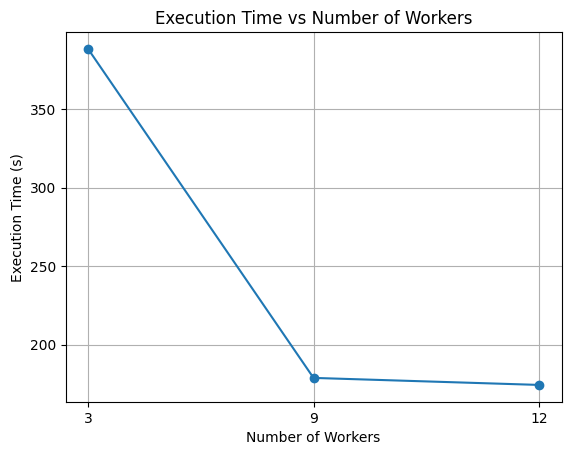

In [32]:
plt.plot(["3","9","12"], execution_times, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Execution Time (s)')  # Label for y-axis
plt.title('Execution Time vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

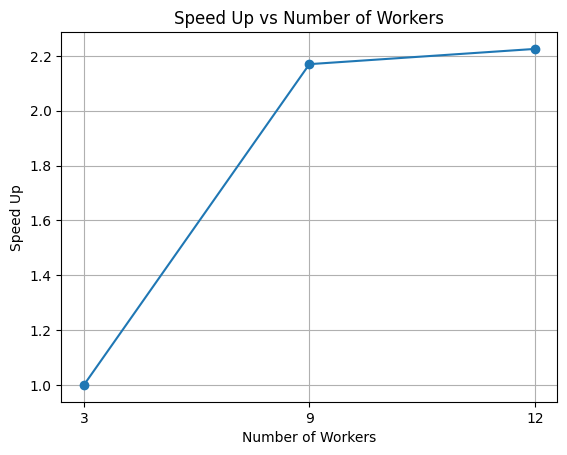

In [33]:
for i in range(0,len(execution_times)):
    speed_up.append(execution_times[0]/execution_times[i])
plt.plot(["3","9","12"], speed_up, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Speed Up')  # Label for y-axis
plt.title('Speed Up vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()